In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings, gc
warnings.filterwarnings('ignore')

from datetime import datetime

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 1000)

In [3]:
data = pd.read_csv('cloud_cost_data')

In [4]:
data.head()

,Date,MeterCategory,CostInBillingCurrency,MeterSubCategory,MeterName,ConsumedService,ResourceLocation
0,2022-12-31,Azure App Service,0.000000,Free Plan,F1 App,microsoft.web,westeurope
1,2022-12-31,Load Balancer,0.018600,Standard,Standard Included LB Rules and Outbound Rules,Microsoft.MachineLearningServices,westeurope
2,2022-12-31,Storage,0.000004,Tables,GRS Data Stored,Microsoft.Storage,northeurope
3,2022-12-31,Load Balancer,0.018600,Standard,Standard Included LB Rules and Outbound Rules,Microsoft.MachineLearningServices,westeurope
4,2022-12-31,Storage,0.014312,Standard SSD Managed Disks,E2 Disks,Microsoft.Compute,northeurope


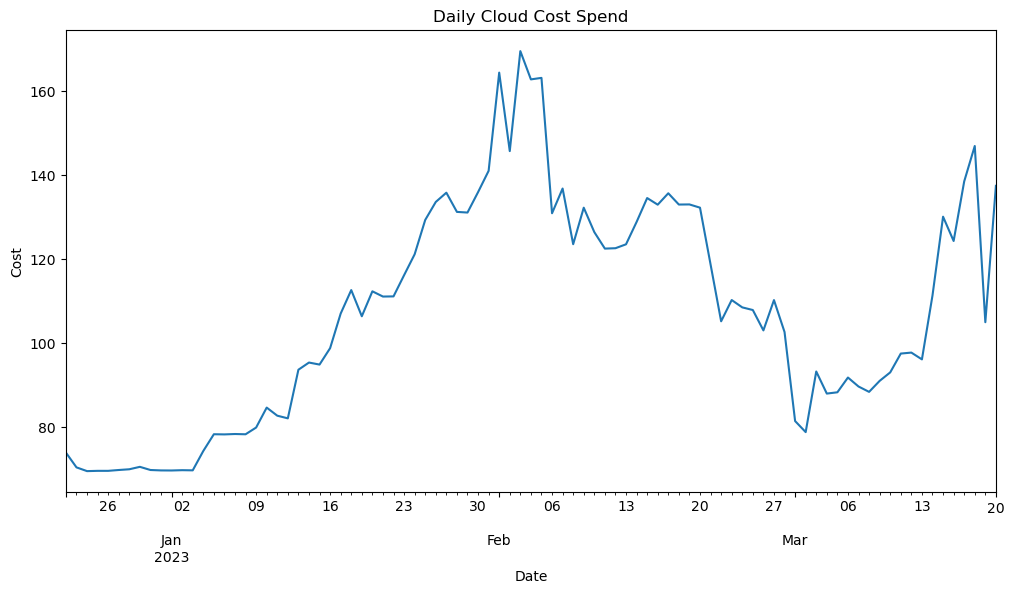

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

# Set 'UsageDateTime' as the DataFrame index for time series analysis
data.set_index('Date', inplace=True)


plt.figure(figsize=(12, 6))
data['CostInBillingCurrency'].resample('D').sum().plot()  # Resampling on daily basis and summing the costs
plt.title('Daily Cloud Cost Spend')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.show()

In [6]:
daily_costs = data['CostInBillingCurrency'].resample('D').sum()
daily_costs_df = pd.DataFrame({'TotalCost': daily_costs})

print(daily_costs_df)

             TotalCost
Date                  
2022-12-22   73.960324
2022-12-23   70.439995
2022-12-24   69.546379
2022-12-25   69.612501
2022-12-26   69.613152
2022-12-27   69.814007
2022-12-28   69.986855
2022-12-29   70.567365
2022-12-30   69.813404
2022-12-31   69.714191
2023-01-01   69.697297
2023-01-02   69.769933
2023-01-03   69.730614
2023-01-04   74.341606
2023-01-05   78.334315
2023-01-06   78.295045
2023-01-07   78.387020
2023-01-08   78.323589
2023-01-09   79.929678
2023-01-10   84.681714
2023-01-11   82.753801
2023-01-12   82.117846
2023-01-13   93.701626
2023-01-14   95.412436
2023-01-15   94.930363
2023-01-16   98.840634
2023-01-17  107.083088
2023-01-18  112.677120
2023-01-19  106.437543
2023-01-20  112.382241
2023-01-21  111.135980
2023-01-22  111.175651
2023-01-23  116.227086
2023-01-24  121.210886
2023-01-25  129.388512
2023-01-26  133.679534
2023-01-27  135.882635
2023-01-28  131.303666
2023-01-29  131.149656
2023-01-30  136.010451
2023-01-31  141.088836
2023-02-01 

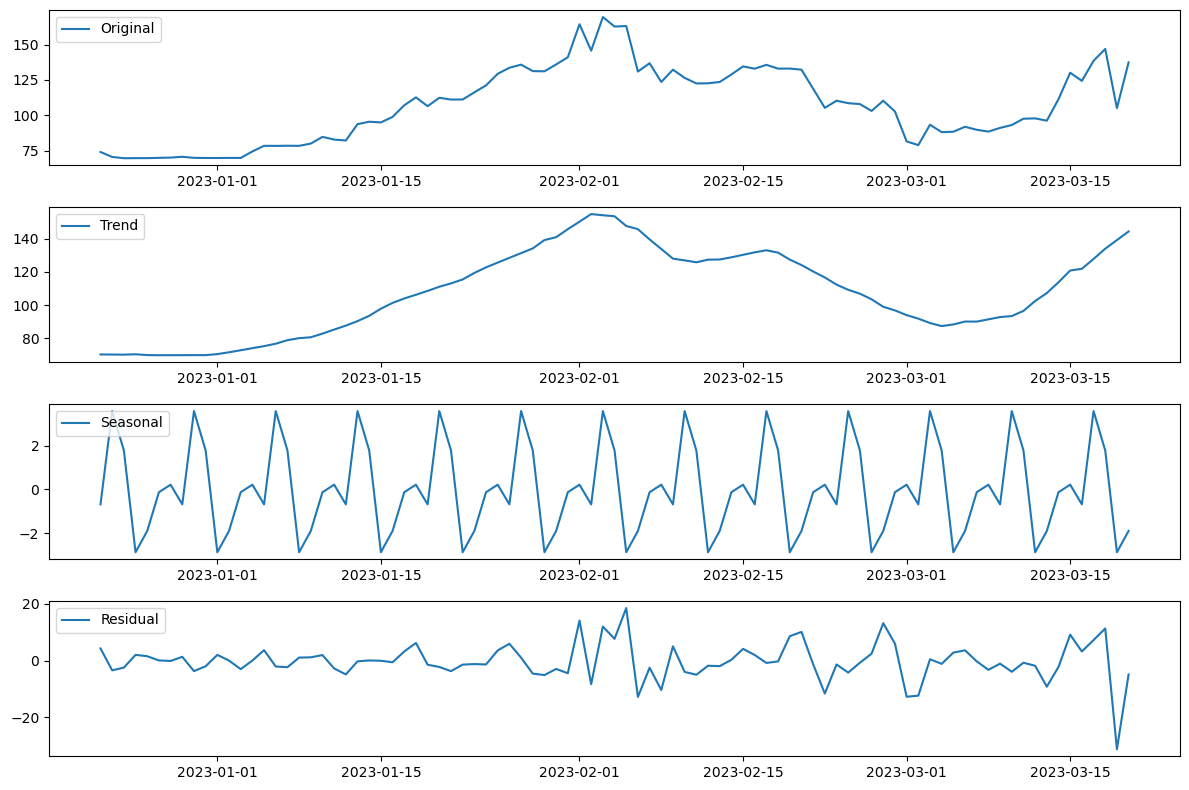

In [7]:

# Resample daily and calculate the sum cost for each day
daily_costs = daily_costs_df['TotalCost'].resample('D').sum()

# Perform seasonal decomposition
result = seasonal_decompose(daily_costs_df, model='additive', extrapolate_trend='freq')

# Plot the original data, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(daily_costs_df, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
# Adf test for stationary
# Null Hypothesis: series posses a unit root and hence is not stationary
# Alternate Hypothesis: Series is stationary

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
dftest = adfuller(daily_costs_df, autolag = 'AIC')
print("1. ADF(Test Statistics) : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
print()
if dftest[1] > 0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')

1. ADF(Test Statistics) :  -1.4850208063027546
2. P-Value :  0.5409078904772467
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 87
5. Critical Values :
	 1% :  -3.5078527246648834
	 5% :  -2.895382030636155
	 10% :  -2.584823877658872

Series is not stationary


In [11]:
# Kpss Test for stationary
# Null Hypothesis : series is stationary
# Alternate Hypothesis: series is non stationary

In [12]:
from statsmodels.tsa.stattools import kpss

In [13]:
stats, p, lags, critical_values = kpss(daily_costs_df, 'c')

In [14]:
print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print((f'critical values : {critical_values}'))

if p < 0.05:
    print('Series is not stationary')

else:
    print('Series is stationary')

Test Statistics : 0.5366529883946495
p-value : 0.03341148910030417
critical values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Series is not stationary


In [15]:
daily_df_diff = daily_costs_df['TotalCost'].diff(1).dropna()

In [16]:
daily_costs_df_diff = pd.DataFrame({'TotalCost': daily_df_diff})

In [17]:
daily_costs_df_diff

,TotalCost
Date,
2022-12-23,-3.520329
2022-12-24,-0.893616
2022-12-25,0.066122
2022-12-26,0.000651
2022-12-27,0.200855
2022-12-28,0.172848
2022-12-29,0.580510
2022-12-30,-0.753961
2022-12-31,-0.099212


In [18]:
dftest = adfuller(daily_costs_df_diff, autolag = 'AIC')
print("1. ADF(Test Statistics) : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
print()
if dftest[1] > 0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')

1. ADF(Test Statistics) :  -12.320422355341632
2. P-Value :  6.770706999545286e-23
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 87
5. Critical Values :
	 1% :  -3.5078527246648834
	 5% :  -2.895382030636155
	 10% :  -2.584823877658872

Series is stationary


<AxesSubplot:xlabel='Date'>

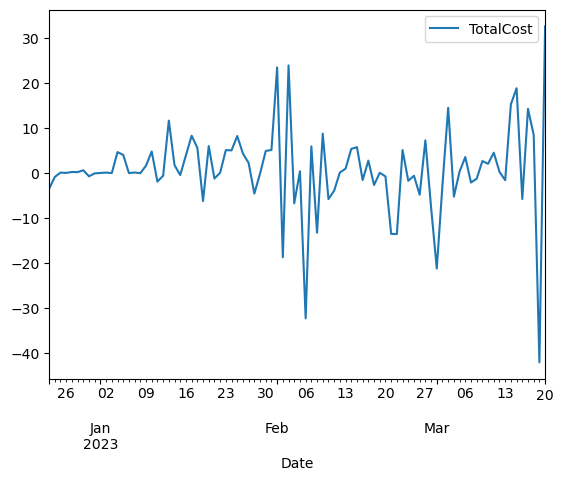

In [19]:
daily_costs_df_diff.plot()

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

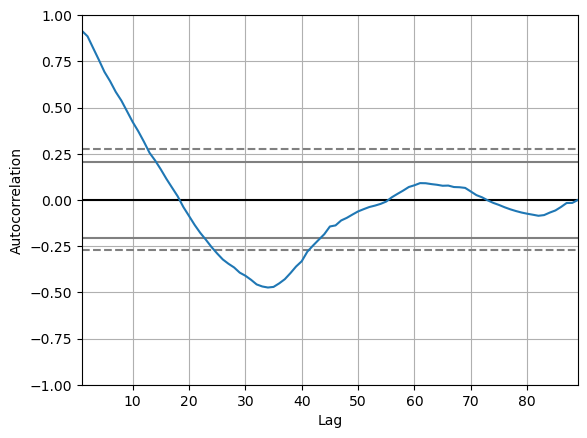

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(daily_costs_df['TotalCost'])
plt.show()

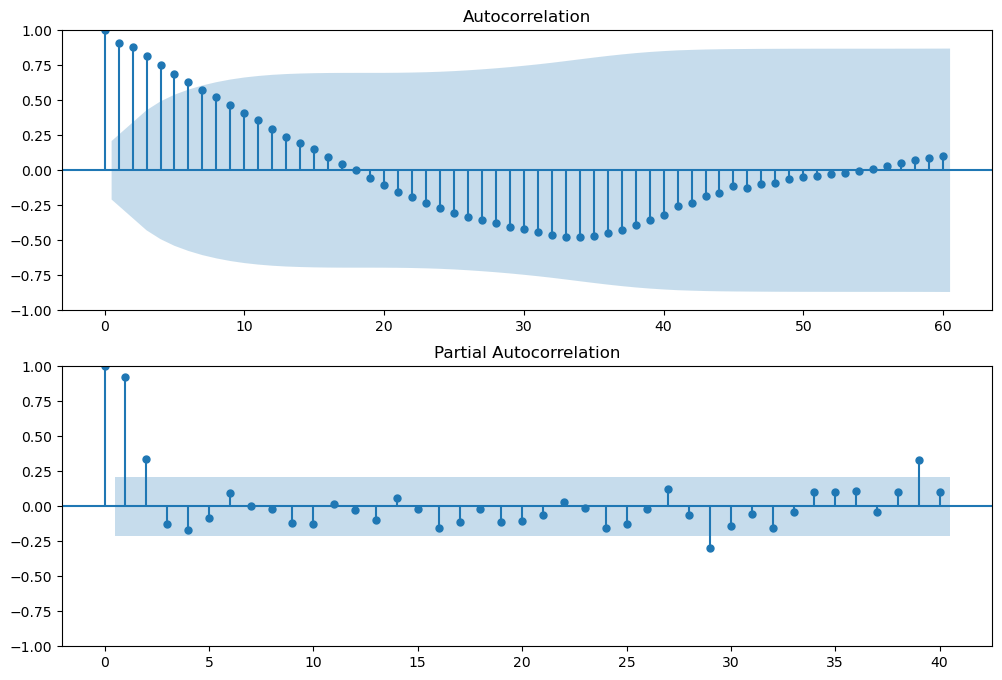

In [22]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(daily_costs_df.iloc[1:],lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(daily_costs_df.iloc[1:],lags=40,ax=ax2)

In [23]:
daily_costs_df_diff.shape

(88, 1)

In [24]:
# daily_costs_df date 2022-12-22 to 2023-03-20

In [25]:
daily_costs_df

,TotalCost
Date,
2022-12-22,73.960324
2022-12-23,70.439995
2022-12-24,69.546379
2022-12-25,69.612501
2022-12-26,69.613152
2022-12-27,69.814007
2022-12-28,69.986855
2022-12-29,70.567365
2022-12-30,69.813404


In [26]:
train_data = daily_costs_df[:len(daily_costs_df) - 7]
test_data = daily_costs_df[len(daily_costs_df) - 7:]

In [27]:
print("Length of train data : ",len(train_data))
print("Length of train data : ",len(test_data))

Length of train data :  82
Length of train data :  7


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              TotalCost   No. Observations:                   82
Model:                 ARIMA(5, 1, 7)   Log Likelihood                -269.508
Date:                Tue, 07 May 2024   AIC                            565.015
Time:                        14:36:42   BIC                            596.143
Sample:                    12-22-2022   HQIC                           577.504
                         - 03-13-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9510      0.501      1.898      0.058      -0.031       1.933
ar.L2          0.1537      0.463      0.332      0.740      -0.754       1.061
ar.L3         -0.6425      0.284     -2.259      0.0

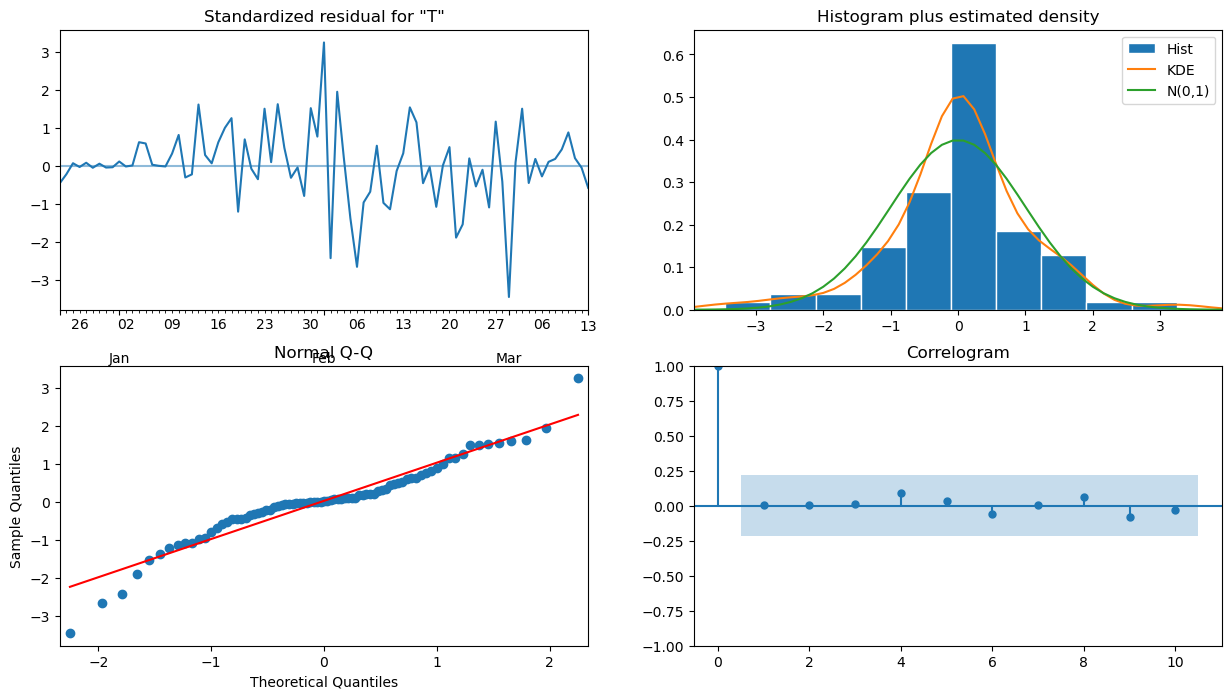

In [28]:
from statsmodels.tsa.arima.model import ARIMA

# fit model
arima_model = ARIMA(train_data['TotalCost'], order=(5,1,7)) 
arima_result = arima_model.fit()


print(arima_result.summary())
arima_result.plot_diagnostics(figsize=(15, 8))
plt.show()

In [29]:
arima_pred = arima_result.predict(start = len(train_data), end = len(daily_costs_df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2023-03-14    97.015885
2023-03-15    93.331417
2023-03-16    92.434268
2023-03-17    89.509104
2023-03-18    91.929256
2023-03-19    93.202386
2023-03-20    95.287160
Freq: D, Name: ARIMA Predictions, dtype: float64

In [30]:
arima_pred_train = arima_result.predict(start = 0, end = len(daily_costs_df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred_train

2022-12-22      0.000000
2022-12-23     73.959381
2022-12-24     71.208167
2022-12-25     69.122604
2022-12-26     69.852294
2022-12-27     69.242176
2022-12-28     70.362800
2022-12-29     70.181716
2022-12-30     70.147845
2022-12-31     69.991931
2023-01-01     68.918587
2023-01-02     69.902980
2023-01-03     69.679867
2023-01-04     70.040793
2023-01-05     74.289259
2023-01-06     78.111363
2023-01-07     78.403151
2023-01-08     78.449281
2023-01-09     77.749925
2023-01-10     79.179592
2023-01-11     84.850236
2023-01-12     83.652005
2023-01-13     82.814864
2023-01-14     93.506893
2023-01-15     94.502438
2023-01-16     94.694048
2023-01-17    100.395223
2023-01-18    104.283079
2023-01-19    114.534156
2023-01-20    107.734156
2023-01-21    111.652573
2023-01-22    113.537204
2023-01-23    106.226617
2023-01-24    120.581616
2023-01-25    118.622030
2023-01-26    130.538059
2023-01-27    137.985875
2023-01-28    131.598979
2023-01-29    136.411659
2023-01-30    125.972317


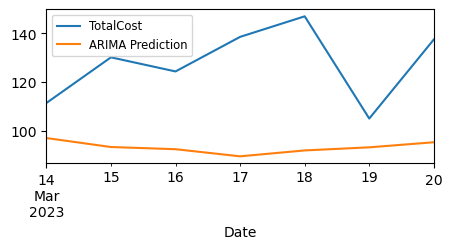

In [31]:
test_data['TotalCost'].plot(figsize = (5,2), legend=True)
arima_pred.plot()
plt.legend(['TotalCost', 'ARIMA Prediction'], loc='upper left', fontsize='small')

In [32]:
test_data['ARIMA_Predictions'] = arima_pred

In [33]:
test_data

,TotalCost,ARIMA_Predictions
Date,,
2023-03-14,111.392723,97.015885
2023-03-15,130.164057,93.331417
2023-03-16,124.372183,92.434268
2023-03-17,138.567702,89.509104
2023-03-18,147.010317,91.929256
2023-03-19,105.024077,93.202386
2023-03-20,137.515357,95.287160


In [34]:
mae = mean_absolute_error(test_data['TotalCost'], arima_pred)
mae

34.476705581282935

In [35]:
mape = mean_absolute_percentage_error(test_data['TotalCost'], arima_pred)
mape*100

25.95979165196422

In [36]:
rmse = np.sqrt(mean_squared_error(test_data['TotalCost'], arima_pred))
rmse

37.6961716508216

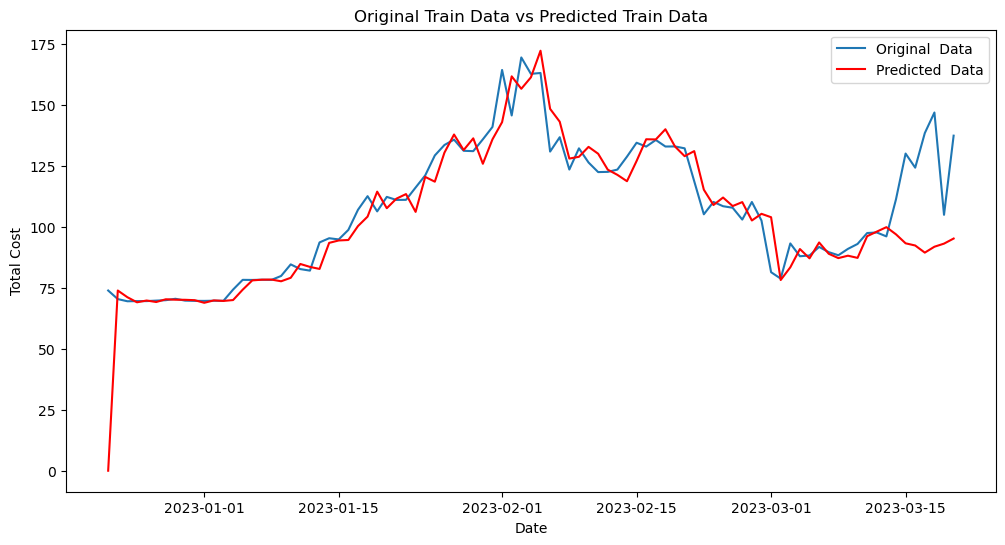

In [37]:
import matplotlib.pyplot as plt

# # Print original train data
# print("Original Train Data:")
# print(train_data)

# # Print predicted train data
# print("\nPredicted Train Data:")
# print(arima_pred)

# Plot original train data and predicted train data
plt.figure(figsize=(12, 6))
plt.plot(daily_costs_df.index, daily_costs_df['TotalCost'], label='Original  Data')
plt.plot(arima_pred_train.index, arima_pred_train, label='Predicted  Data', color='red')
plt.xlabel('Date')
plt.ylabel('Total Cost')
plt.title('Original Train Data vs Predicted Train Data')
plt.legend()
plt.show()


In [ ]:
forecast_steps = 7  # Adjust this value based on how many future dates you want to forecast
forecast_future = arima_result.forecast(steps=forecast_steps)


In [ ]:
forecast_future